# ADR Code Synth - Workflow Testing Notebook

This notebook demonstrates and tests the ADR (Architecture Decision Record) generation workflow.

## Overview

The ADR Code Synth application uses LangGraph to orchestrate a multi-step workflow that:
1. **Generates architectural context** from source code
2. **Analyzes Terraform files** for infrastructure patterns (minor and major versions)
3. **Validates with source code** to ensure accurate analysis
4. **Compares architectures** between versions
5. **Generates ADRs** documenting key architectural decisions

## Prerequisites

- OpenAI API key configured in `.env` file
- Project input files in `project-inputs/` directory
- Knowledge base file in `knowledge/` directory

## Usage

- **Full workflow**: Run cells in order from 1-9
- **Individual node testing**: Run cells in section 4 to test each node independently

In [1]:
# 1. Setup and Configuration
import os
from dotenv import load_dotenv
from datetime import datetime
import logging

from pathlib import Path
import sys
sys.path.append('..')  # Add parent directory to path

from IPython.display import Image, display, Markdown

from config import Settings, get_llm_config, load_project_config, initialize_llm, get_settings

from workflow import ADRWorkflow #create_workflow, run_workflow
from nodes.context_generator_node import context_generator_node
from nodes.terraform_analyzer_node import terraform_analyzer_minor_node, terraform_analyzer_major_node
from nodes.source_code_analyzer_node import source_code_analyzer_minor_node, source_code_analyzer_major_node
from nodes.architecture_diff_node import architecture_diff_node
from nodes.adr_generator_node import adr_generator_node


In [2]:
# Load environment variables from .env file
print(load_dotenv())

# Verify environment variables are loaded
print("Environment variables loaded:")
print(f"OPENAI_API_KEY: {'***' + os.getenv('OPENAI_API_KEY', '')[-4:] if os.getenv('OPENAI_API_KEY') else 'NOT SET'}")
print(f"OPENAI_MODEL: {os.getenv('OPENAI_MODEL_NAME')}") 
print(f"GROQ_API_KEY: {'***' + os.getenv('GROQ_API_KEY', '')[-4:] if os.getenv('GROQ_API_KEY') else 'NOT SET'}")
print(f"GROQ_MODEL: {os.getenv('GROQ_MODEL_NAME')}") 

True
Environment variables loaded:
OPENAI_API_KEY: ***GH0A
OPENAI_MODEL: gpt-4.1-mini
GROQ_API_KEY: ***q0Vy
GROQ_MODEL: llama-3.3-70b-versatile


In [3]:
logging.basicConfig(
    stream=sys.stdout, 
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True # Ensures reconfiguration works in notebooks
)

In [4]:
# Load environment-based settings (from .env)
settings = Settings()
print("Settings loaded from .env:")
print(f"  Model: {settings.openai_model}")
print(f"  Temperature: {settings.temperature}")
print(f"  Max Tokens: {settings.max_tokens}")

Settings loaded from .env:
  Model: gpt-4.1-mini
  Temperature: 0.1
  Max Tokens: None


---

## Project Initialization

This section loads the project configuration and creates the workflow graph.

In [5]:
# Load project configuration from YAML
# Available projects: abelaa, chef, serverlessmike

project_dir = "../project-inputs/abelaa"
# project_dir = "../project-inputs/chef"
# project_dir = "../project-inputs/serverlessmike"


2026-02-26 16:47:29 - INFO - 
LLM initialized:
2026-02-26 16:47:29 - INFO -   Model: llama-3.3-70b-versatile
2026-02-26 16:47:29 - INFO -   Temperature: 0.1
2026-02-26 16:47:29 - INFO - 
Project configuration loaded:
2026-02-26 16:47:29 - INFO -   Project Name: abelaa
2026-02-26 16:47:29 - INFO -   Terraform Minor: abelaa_cloud_evolucion_menor.tf
2026-02-26 16:47:29 - INFO -   Terraform Major: abelaa_cloud_evolucion_mayor.tf
2026-02-26 16:47:29 - INFO -   LLM Model: gpt-4.1-mini
2026-02-26 16:47:29 - INFO - Single source code ZIP detected, treating as major branch
2026-02-26 16:47:29 - INFO -   Source Code Major: ../project-inputs/abelaa/abelaa_app.zip
2026-02-26 16:47:29 - INFO -   Knowledge Base: knowledge/IAC.txt
2026-02-26 16:47:29 - INFO - Initial state: {'project_name': 'abelaa', 'terraform_minor': '../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf', 'terraform_major': '../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf', 'source_code_zip_minor': '', 'source_code_zip

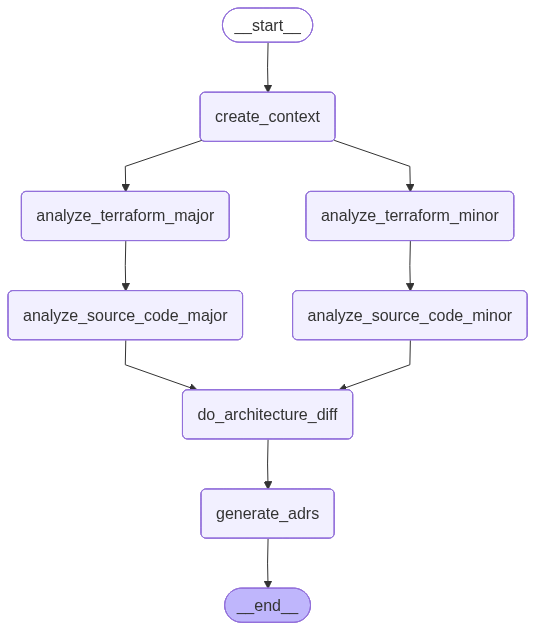

In [6]:
# Create the workflow graph
workflow = ADRWorkflow(project_dir) #, llm=None)

initial_state = workflow.create(include_terraform=True, include_knowledge=True)

print("\nWorkflow created successfully!")
display(workflow.get_graph())

In [7]:
print("\nInitial state prepared:")
for key, value in initial_state.items():
    print(f"  {key}: {value}")



Initial state prepared:
  project_name: abelaa
  terraform_minor: ../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf
  terraform_major: ../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf
  source_code_zip_minor: 
  source_code_zip_major: ../project-inputs/abelaa/abelaa_app.zip
  knowledge_base: knowledge/IAC.txt
  timestamp: 2026-02-26T16:47:29.525569


---

In [8]:
result = await workflow.run(initial_state)
result

2026-02-26 16:47:40 - INFO - RUNNING workflow for project: ../project-inputs/abelaa - 6618478d-06a4-4317-bd56-43bbbd8981a2
2026-02-26 16:47:40 - INFO - STEP: context_generator_node
2026-02-26 16:47:40 - INFO - STEP: terraform_analyzer_major_node
2026-02-26 16:47:40 - WARNING - File not found: knowledge/IAC.txt
2026-02-26 16:47:40 - INFO - STEP: terraform_analyzer_minor_node
2026-02-26 16:47:40 - WARNING - File not found: knowledge/IAC.txt
2026-02-26 16:47:41 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 413 Payload Too Large"


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama-3.3-70b-versatile` in organization `org_01hwftp8fxen3t6x3179fgfzds` service tier `on_demand` on tokens per minute (TPM): Limit 12000, Requested 23959, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [9]:
llm = get_llm_config().llm

---
## Individual Node Testing


In [ ]:
# Test context generator node
print("\n--- Testing Context Generator Node ---")

context_result = await context_generator_node(initial_state, llm=llm)

print(f"Architectural context generated: {len(context_result['architectural_context'])} characters")
# print(f"Project structure extracted: {len(context_result['project_structure'])} characters")
print()

# display(Markdown(context_result['architectural_context']))
# display(Markdown(context_result['project_structure']))
# print(context_result['project_structure'])

context_result


--- Testing Context Generator Node ---
2026-02-26 13:13:35 - INFO - STEP: context_generator_node
Architectural context generated: 7145 characters



{'project_name': 'abelaa',
 'terraform_minor': '../project-inputs/abelaa/abelaa_cloud_evolucion_menor.tf',
 'terraform_major': '../project-inputs/abelaa/abelaa_cloud_evolucion_mayor.tf',
 'source_code_zip_minor': '',
 'source_code_zip_major': '../project-inputs/abelaa/abelaa_app.zip',
 'knowledge_base': 'knowledge/IAC.txt',
 'timestamp': '2026-02-26T11:41:38.003565',
 'architectural_context': '\n# Theoretical Introduction to Software Architecture, Monolithic Architecture, and Microservices Architecture\n\n## 1. Software Architecture\n\n### Definition\nSoftware architecture refers to the fundamental structures of a software system and the discipline of creating such structures and systems. It involves the high-level structuring of software components, their relationships, and the principles and guidelines governing their design and evolution over time.\n\n### Purpose and Importance\n- **Blueprint for Development:** Acts as a blueprint guiding the design and implementation of the system.

In [13]:
# for k, v in context_result['source_code_dict'].items():
#     print("="*10+" "+k)
#     print(v)
#     print("="*20)

In [14]:
# display(Markdown(context_result['architectural_context'].strip()))
# print(context_result['architectural_context'].strip())


---

In [15]:
# path_knowledge_base = context_result['knowledge_base']
# context_result['knowledge_base'] = "../" +  path_knowledge_base if not path_knowledge_base.startswith("../") else path_knowledge_base


In [16]:
print("\n--- Testing Terraform Analyzer Minor Node ---")

terraform_result1 = await terraform_analyzer_minor_node(context_result, llm=llm)

# display(Markdown(context_result['terraform_analysis_minor']))
terraform_result1['terraform_analysis_minor']


--- Testing Terraform Analyzer Minor Node ---
2026-02-26 13:13:35 - INFO - STEP: terraform_analyzer_minor_node
2026-02-26 13:13:35 - WARNING - File not found: knowledge/IAC.txt
2026-02-26 13:13:40 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'microservices': False,
 'confidence': 0.85,
 'signals_for': ['Use of Terraform modules for modularity [C# module "covid-dev"]',
  'Use of AWS infrastructure components suggesting potential for distributed deployment [C# provider and remote state data]'],
 'signals_against': ['Single module deployment indicating a single application unit [C# module "covid-dev"]',
  'No evidence of multiple independent services or microservices modules [C# entire Terraform code]',
  'No explicit inter-service communication patterns such as APIs, messaging, or event-driven mechanisms [C# Terraform code]',
  'No indication of decentralized data management or multiple databases [C# Terraform code]',
  'Single deployment artifact implied by single module and single EC2 instance configuration [C# variables and module usage]']}

In [17]:
print("\n--- Testing Terraform Analyzer Major Node ---")

terraform_result2 = await terraform_analyzer_major_node(context_result, llm=llm)

# display(Markdown(context_result['terraform_analysis_major']))
terraform_result2['terraform_analysis_major']


--- Testing Terraform Analyzer Major Node ---
2026-02-26 13:13:40 - INFO - STEP: terraform_analyzer_major_node
2026-02-26 13:13:40 - WARNING - File not found: 
2026-02-26 13:13:49 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'microservices': False,
 'confidence': 0.9,
 'signals_for': ['Use of Terraform modules for infrastructure reuse [C# modules/pcmt-network and modules/pcmt]',
  'Multiple environment-specific Terraform configurations referencing shared modules and remote states [C# beta, demo, covid-dev, etc.]'],
 'signals_against': ['Single EC2 instance per deployment with no evidence of multiple independent services or containers [C# modules/pcmt compute.tf aws_instance.app]',
  'No explicit service decomposition or multiple independently deployable services in Terraform code [C# all main.tf and module usage]',
  'Communication is via DNS and Route53 records pointing to single IPs, no async messaging or API gateway patterns [C# modules/pcmt network.tf aws_route53_record]',
  'No orchestration or container management (e.g., ECS, EKS, Lambda) indicating distributed microservices [C# all]',
  'Deployment appears as single units per environment, not multiple independent deployables [C# demo, covid-dev, ma

---

In [18]:
print("\n--- Testing Source Code Analyzer Minor Node ---")

source_code_result1 = await source_code_analyzer_minor_node(context_result, llm=llm)

source_code_result1['improved_analysis_minor']


--- Testing Source Code Analyzer Minor Node ---
2026-02-26 13:13:49 - INFO - STEP: source_code_analyzer_minor_node
2026-02-26 13:13:49 - WARNING - Source code branch [minor] not available, using Terraform-only analysis


{'microservices': False,
 'confidence': 0.85,
 'signals_for': ['Use of Terraform modules for modularity [C# module "covid-dev"]',
  'Use of AWS infrastructure components suggesting potential for distributed deployment [C# provider and remote state data]'],
 'signals_against': ['Single module deployment indicating a single application unit [C# module "covid-dev"]',
  'No evidence of multiple independent services or microservices modules [C# entire Terraform code]',
  'No explicit inter-service communication patterns such as APIs, messaging, or event-driven mechanisms [C# Terraform code]',
  'No indication of decentralized data management or multiple databases [C# Terraform code]',
  'Single deployment artifact implied by single module and single EC2 instance configuration [C# variables and module usage]']}

In [19]:
# display(Markdown(context_result['improved_analysis_minor']))
# print(context_result['improved_analysis_minor']) #.strip('"')

In [20]:
print("\n--- Testing Source Code Analyzer Major Node ---")

source_code_result2 = await source_code_analyzer_major_node(context_result, llm=llm)

source_code_result2['improved_analysis_major']


--- Testing Source Code Analyzer Major Node ---
2026-02-26 13:13:50 - INFO - STEP: source_code_analyzer_major_node
2026-02-26 13:13:50 - INFO - Source code found for major branch: ../project-inputs/abelaa/abelaa_app.zip
2026-02-26 13:13:50 - INFO - Extracted 2 files for major branch
2026-02-26 13:14:53 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'# Architecture Analysis of the Given Solution\n\n---\n\n## 1. Project Structure and Codebase Organization\n\n### Overview\n\n- The project consists primarily of PHP source files, with no Python or Terraform files present in the provided source code.\n- The root directory contains `AppKernel.php` and a `config` directory with multiple YAML and PHP configuration files.\n- The `AppKernel.php` is a Symfony Kernel class, responsible for registering bundles (modules) and loading environment-specific configurations.\n- The configuration files (`config.yml`, `routing.yml`, `parameters.php`, etc.) follow Symfony’s standard conventions for environment-based configuration management.\n\n### Monolithic vs Modular\n\n- The codebase is organized as a **monolithic Symfony application**:\n  - All functionality is bundled into a single Symfony Kernel (`AppKernel.php`).\n  - Multiple bundles (Symfony’s modular units) are registered within this single kernel, but they are all loaded and deployed togethe

In [21]:
# display(Markdown(context_result['improved_analysis_major']))
# print(context_result['improved_analysis_major']) #.strip('"')

---

In [22]:
print("\n--- Testing Diff Analysis Node ---")

diff_result = await architecture_diff_node(context_result, llm=llm)

diff_result['architecture_diff']


--- Testing Diff Analysis Node ---
2026-02-26 13:14:53 - INFO - STEP: architecture_diff_node
2026-02-26 13:15:28 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'# Key Architecture Decisions in Migrating from Hybrid to Microservices Architecture\n\n---\n\n## 1. Architectural Decomposition: From Single Monolith to Multiple Independent Services\n\n**Description:**  \nThe migration involved decomposing the single monolithic application (hybrid version) into multiple independently deployable microservices, each implemented as separate Lambda functions.\n\n**Key Differences Necessitating This Decision:**  \n- Hybrid version is a single deployment unit with tightly coupled components and a single Lambda function alongside a monolith.  \n- Microservices version splits functionality into multiple Lambda functions, each encapsulating a distinct business capability or service boundary.  \n- The microservices version introduces an API Gateway to route requests to these independent services.\n\n**Architectural Impact:**  \n- Enables independent development, deployment, and scaling of services.  \n- Improves fault isolation; failure in one service does not

In [23]:
# display(Markdown(context_result['architecture_diff']))
# print(context_result['architecture_diff']) #.strip('"')

---

In [24]:
print("\n--- Testing ADR Generation Node ---")

adr_result = await adr_generator_node(context_result, llm=llm)

adr_result['adr_files']


--- Testing ADR Generation Node ---
2026-02-26 13:15:28 - INFO - STEP: adr_generator_node
2026-02-26 13:17:16 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'abelaa_ADR_1.md': '# ADR: Architectural Decomposition\n\n## Title\nDecompose Monolithic Application into Independent Microservices\n\n## Status\nAccepted\n\n## Motivation\nThe existing hybrid architecture consists of a single monolithic application combined with a single Lambda function, resulting in tightly coupled components and a single deployment unit. This structure limits scalability, fault isolation, and independent deployment capabilities. To address these limitations and improve agility, scalability, and resilience, it is necessary to decompose the monolith into multiple independently deployable services, each encapsulating distinct business capabilities.\n\n## Decision Drivers\n- Need for independent development and deployment of components\n- Requirement for improved fault isolation to prevent cascading failures\n- Scalability demands requiring fine-grained scaling of services\n- Desire to reduce coupling and improve maintainability\n- Organizational need to align teams ar

In [ ]:
# context_result = result

# folder_path = Path("../output-adrs/"+project_config['project_name'])
# folder_path.mkdir(parents=True, exist_ok=True) 

for k,adr in context_result['adr_files'].items():
    print("="*10+" "+k)
    display(Markdown(adr))
    print(("="*30))
    print()
    # with (folder_path / k).open("w") as file:
    #     file.write(adr)

    # print(f"File '{k}' written to '{folder_path}'")

========== abelaa_ADR_1.md


# ADR: Architectural Decomposition

## Title
Decompose Monolithic Application into Independent Microservices

## Status
Accepted

## Motivation
The existing hybrid architecture deploys a single monolithic application unit encapsulated in one Lambda function, which limits scalability, fault isolation, and independent development. To improve scalability, resilience, and enable faster development cycles, it is necessary to decompose the monolithic application into multiple independent services, each representing a distinct business capability. This decomposition allows teams to develop, deploy, and scale services independently, addressing the growing complexity and operational demands of the system.

## Decision Drivers
- Need for independent development and deployment of services
- Requirement for improved fault isolation to limit failure impact
- Scalability demands requiring independent scaling of components
- Maintainability challenges in a large monolithic codebase
- Organizational structure favoring service-aligned teams

## Main Decision
The monolithic application is decomposed into multiple independent Lambda functions, each encapsulating a specific business capability or service. This microservices decomposition enables independent development, deployment, and scaling of services. Clear service boundaries and contracts are established to manage interactions and dependencies between services, addressing the increased complexity introduced by decomposition.

## Alternatives
- Monolithic Architecture: Retain a single unified application unit with one Lambda function
- Modular Monolith: Decompose internally into modules but deploy as a single unit

## Pros
Main decision:
- Enables independent development and deployment of services
- Improves fault isolation by limiting blast radius
- Facilitates scalability of individual services

Monolithic Architecture:
- Simpler deployment and operational model
- Lower initial complexity

Modular Monolith:
- Maintains single deployment unit while improving modularity
- Easier to manage than fully distributed services

## Cons
Main decision:
- Increased architectural and operational complexity
- Requires clear service contracts and boundary management
- More complex testing and debugging

Monolithic Architecture:
- Poor scalability and fault isolation
- Slower development cycles as codebase grows

Modular Monolith:
- Limited scalability benefits
- Still a single point of failure
- Deployment and scaling remain coarse-grained

## Consequences
Short-term, the decomposition increases complexity in managing service boundaries and requires investment in defining service contracts and deployment pipelines. Long-term, it improves scalability, resilience, and development velocity. The architecture gains better fault isolation and flexibility but requires enhanced operational capabilities and governance to manage distributed services effectively.

## Validation
Validation to be defined in future iterations.

## Additional Information



========== abelaa_ADR_2.md


# ADR: Communication Style

## Title
Adopt API Gateway and Explicit Service Interfaces for Inter-Service Communication

## Status
Accepted

## Motivation
The hybrid architecture lacks explicit inter-service communication mechanisms, resulting in tightly coupled components and limited flexibility. To support the microservices decomposition, a robust communication mechanism is needed to enable loose coupling, independent evolution of services, and orchestration of requests across multiple services. Introducing an API Gateway provides a unified entry point and facilitates management of service interfaces, security, and monitoring.

## Decision Drivers
- Requirement for loose coupling between services
- Need for independent evolution of service interfaces
- Security and monitoring requirements for service interactions
- Desire to orchestrate requests across multiple services
- Operational need to manage network latency and reliability

## Main Decision
An API Gateway is introduced as the primary communication mechanism, routing client requests to multiple Lambda functions representing microservices. This approach enables well-defined APIs for each service, facilitating loose coupling and independent evolution. The API Gateway also centralizes concerns such as authentication, authorization, rate limiting, and monitoring, addressing operational and security requirements.

## Alternatives
- Direct Service-to-Service Communication: Services communicate directly without an API Gateway
- Message-Based Communication: Use asynchronous messaging or event-driven communication between services

## Pros
Main decision:
- Facilitates loose coupling via well-defined APIs
- Centralizes security, monitoring, and request routing
- Enables orchestration and aggregation of service calls

Direct Service-to-Service Communication:
- Simpler architecture without additional gateway layer
- Potentially lower latency

Message-Based Communication:
- Enables asynchronous, decoupled interactions
- Improves resilience and scalability

## Cons
Main decision:
- Introduces network latency
- Adds operational complexity in managing API Gateway
- Requires robust API management and security

Direct Service-to-Service Communication:
- Tight coupling between services
- Harder to manage security and monitoring
- Increased complexity in client logic

Message-Based Communication:
- Increased complexity in designing eventual consistency
- More complex debugging and testing
- Potentially higher latency for synchronous needs

## Consequences
The introduction of an API Gateway improves modularity and security but adds network latency and operational overhead. It enables independent evolution of services and centralized management of cross-cutting concerns. Over time, this supports scalability and maintainability but requires investment in API lifecycle management and monitoring infrastructure.

## Validation
Validation to be defined in future iterations.

## Additional Information



========== abelaa_ADR_3.md


# ADR: Deployment Model

## Title
Enable Independent Deployment of Microservices

## Status
Accepted

## Motivation
The hybrid architecture uses a single Terraform module to deploy a unified application, resulting in a monolithic deployment artifact. This limits the ability to release features rapidly and independently, slows down development cycles, and increases risk during deployments. To achieve continuous delivery and faster release cycles, it is necessary to enable independent deployment of each microservice and its associated infrastructure components.

## Decision Drivers
- Requirement for continuous delivery and faster release cycles
- Need to reduce deployment risk by isolating changes
- Operational need for automated and repeatable deployments
- Complexity of managing multiple services and versions
- Organizational demand for autonomous teams

## Main Decision
Each microservice is deployed independently as a separate Lambda function along with its infrastructure components, using modular Terraform configurations. This enables teams to deploy, version, and rollback services independently, supporting continuous integration and continuous deployment (CI/CD) practices. Deployment automation and sophisticated pipelines are established to manage the increased operational complexity.

## Alternatives
- Unified Deployment: Continue deploying all services as a single unit
- Partial Deployment: Group related services into deployment units

## Pros
Main decision:
- Supports continuous delivery and faster release cycles
- Reduces deployment risk by isolating changes
- Enables independent versioning and rollback

Unified Deployment:
- Simpler deployment process
- Easier to coordinate releases

Partial Deployment:
- Balances deployment granularity and complexity
- Easier to manage than fully independent deployments

## Cons
Main decision:
- Increased operational complexity
- Requires sophisticated CI/CD pipelines
- More complex versioning and rollback strategies

Unified Deployment:
- Slower release cycles
- Higher risk of deployment failures affecting entire system

Partial Deployment:
- Limited flexibility compared to fully independent deployments
- Potential coupling within deployment units

## Consequences
Short-term, independent deployment requires investment in automation and pipeline development. Long-term, it enables faster innovation, reduces deployment risk, and improves system resilience. However, it increases operational complexity and necessitates robust monitoring and rollback mechanisms.

## Validation
Validation to be defined in future iterations.

## Additional Information



========== abelaa_ADR_4.md


# ADR: Data Management

## Title
Adopt Decentralized Data Management per Microservice

## Status
Accepted

## Motivation
The hybrid architecture uses a shared database schema consistent with a monolithic design, which creates tight coupling between components and limits scalability and service autonomy. To align with microservices principles and enable independent scaling and evolution, each service must manage its own data or data access patterns. This decentralization supports service autonomy but introduces challenges in maintaining data consistency and managing distributed transactions.

## Decision Drivers
- Need for service autonomy and independent scalability
- Requirement to reduce coupling between services
- Challenges in maintaining data consistency across distributed services
- Operational complexity of managing multiple data stores
- Necessity to design for eventual consistency and synchronization

## Main Decision
Each microservice manages its own data store or data access patterns, decentralizing data management. This approach enhances service autonomy and scalability, allowing services to choose appropriate data technologies and schemas. To address consistency challenges, eventual consistency models and data synchronization mechanisms are designed and implemented where necessary.

## Alternatives
- Shared Database Schema: Continue using a single shared database for all services
- Hybrid Approach: Shared database with service-specific schemas

## Pros
Main decision:
- Enhances service autonomy and scalability
- Enables technology diversity per service
- Reduces coupling between services

Shared Database Schema:
- Simplifies data consistency
- Easier to query across domains

Hybrid Approach:
- Balances autonomy and consistency
- Easier migration path from monolith

## Cons
Main decision:
- Complex to maintain data consistency
- Requires design of distributed transactions or eventual consistency
- Increased operational overhead

Shared Database Schema:
- Tight coupling between services
- Limits scalability and independent evolution
- Single point of failure

Hybrid Approach:
- Partial coupling remains
- Complexity in managing schemas and access controls

## Consequences
Decentralized data management improves scalability and service independence but increases complexity in data consistency and transaction management. It necessitates careful design of synchronization and eventual consistency mechanisms, impacting development and operational practices. Over time, this supports flexible evolution and resilience of services.

## Validation
Validation to be defined in future iterations.

## Additional Information



========== abelaa_ADR_5.md


# ADR: Infrastructure Modularity and Scalability

## Title
Modularize Infrastructure to Support Independent Services and Scalability

## Status
Accepted

## Motivation
The hybrid architecture deploys infrastructure as a single Terraform module, tightly coupling deployment and scaling of components. This limits the ability to scale services independently and reuse infrastructure components. To support the microservices architecture, infrastructure must be modularized to enable independent scaling, deployment, and management of services and their infrastructure components.

## Decision Drivers
- Requirement for independent scaling of services and infrastructure
- Need for infrastructure as code modularity and reuse
- Operational complexity in managing dependencies and orchestration
- Desire to improve scalability and flexibility
- Organizational need for clear infrastructure ownership

## Main Decision
The infrastructure is restructured into multiple modular components, each supporting an independent microservice or infrastructure element such as Lambda functions and API Gateway. Modular Terraform configurations are used to enable reuse, independent deployment, and scaling. This modularity improves scalability and operational flexibility but requires careful management of dependencies and orchestration between modules.

## Alternatives
- Monolithic Infrastructure Module: Retain a single Terraform module for all infrastructure
- Partial Modularization: Group related infrastructure components into modules

## Pros
Main decision:
- Enables independent scaling and deployment
- Facilitates infrastructure reuse and modularity
- Improves operational flexibility

Monolithic Infrastructure Module:
- Simpler infrastructure management
- Easier to coordinate changes

Partial Modularization:
- Balances modularity and complexity
- Easier transition from monolith

## Cons
Main decision:
- Increased complexity in managing dependencies
- Requires orchestration and coordination between modules
- Higher operational overhead

Monolithic Infrastructure Module:
- Limits scalability and flexibility
- Tightly coupled infrastructure

Partial Modularization:
- Partial benefits of modularity
- Some coupling remains

## Consequences
Modular infrastructure improves scalability and flexibility, enabling independent service evolution and deployment. However, it increases complexity in dependency management and orchestration. Long-term benefits include improved maintainability and operational agility, while short-term requires investment in modular design and tooling.

## Validation
Validation to be defined in future iterations.

## Additional Information


---